Questions: 
1. Is this recommendation supported by current clinical evidence? Answer "Yes", "No", or "Unknown".
2. How strong is this recommendation? Give a number from 1 (very weak) to 5 (very strong).
3. What's the quality of the supporting evidence? Give a number from 1 (very low) to 5 (very high).
4. Is this recommendation supported by randomized controlled trials (RCTs)? Answer "Yes", "No", or "Unknown".
5. Is it supported by observational or nonrandomized studies? Answer "Yes", "No", or "Unknown".
6. Is it a concensus of expert opinion based on clinical experience? Answer "Yes", "No", or "Unknown".

=== Proportion of model_supported values ===
model_supported
Yes        0.938783
Unknown    0.051143
No         0.010074
Name: count, dtype: float64


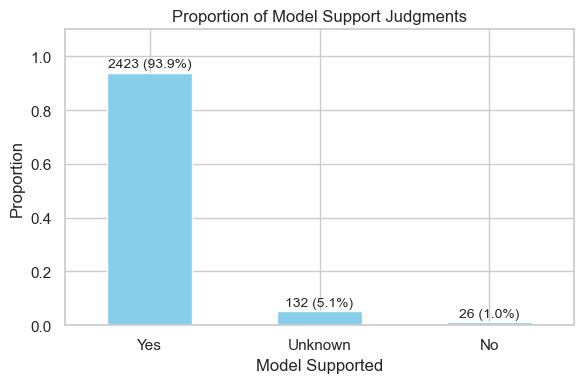

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# === 1. Load JSON data ===
with open("evidence_eval_results.json", "r") as f:
    data = json.load(f)

# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(data, orient="index")

# === 2. Compute count and proportion
support_counts_abs = df["model_supported"].value_counts()
support_counts = support_counts_abs / support_counts_abs.sum()

print("=== Proportion of model_supported values ===")
print(support_counts)

# Bar plot with value labels
plt.figure(figsize=(6, 4))
ax = support_counts.plot(kind="bar", color="skyblue")

# Add text labels (count + percentage)
for i, label in enumerate(support_counts.index):
    count = support_counts_abs[label]
    pct = support_counts[label]
    ax.text(i, pct + 0.01, f"{count} ({pct:.1%})", ha='center', va='bottom', fontsize=10)

# Final formatting
plt.title("Proportion of Model Support Judgments")
plt.xlabel("Model Supported")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()



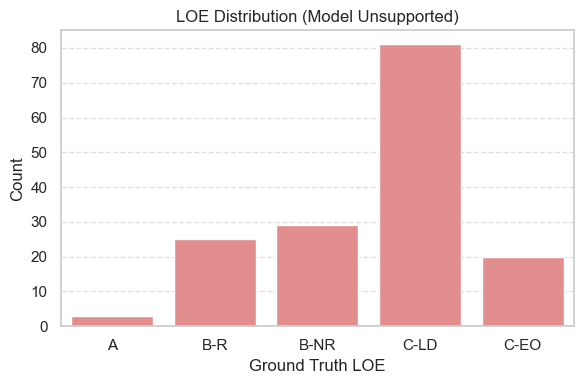

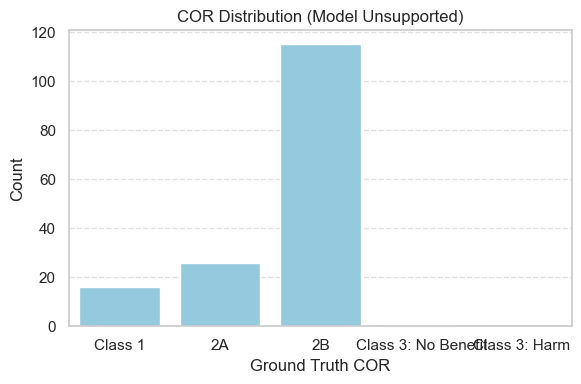

In [3]:
# Filter samples with model_supported in ['No', 'Unknown']
unsupported_df = df[df["model_supported"].isin(["No", "Unknown"])]

# --- LOE distribution
loe_counts = unsupported_df["ground_truth_loe"].value_counts().reindex(["A", "B-R", "B-NR", "C-LD", "C-EO"], fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(x=loe_counts.index, y=loe_counts.values, color="lightcoral")
plt.title("LOE Distribution (Model Unsupported)")
plt.xlabel("Ground Truth LOE")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- COR distribution
cor_order = ["Class 1", "2A", "2B", "Class 3: No Benefit", "Class 3: Harm"]
cor_counts = (
    unsupported_df["ground_truth_cor"]
    .str.strip()
    .str.title()
    .value_counts()
    .reindex(cor_order, fill_value=0)
)

plt.figure(figsize=(6, 4))
sns.barplot(x=cor_counts.index, y=cor_counts.values, color="skyblue")
plt.title("COR Distribution (Model Unsupported)")
plt.xlabel("Ground Truth COR")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


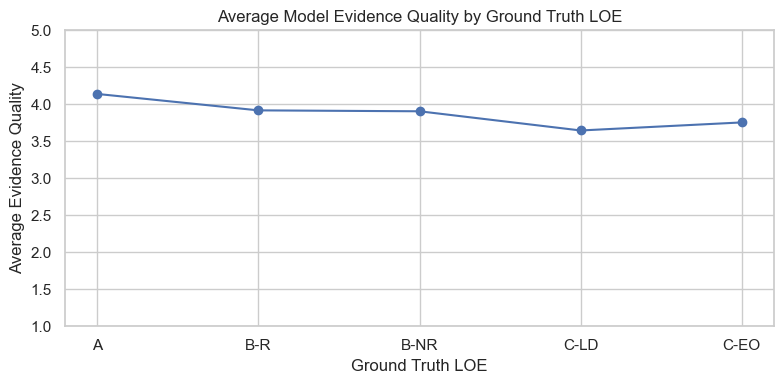

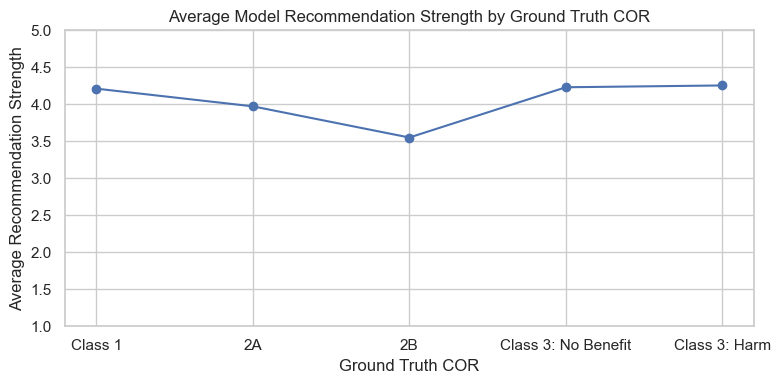

In [10]:
import matplotlib.pyplot as plt

# Define desired LOE order
loe_order = ["A", "B-R", "B-NR", "C-LD", "C-EO"]

# Group by LOE and calculate mean evidence quality
mean_quality = (
    df.groupby("ground_truth_loe")["model_evidence_quality"]
    .mean()
    .reindex(loe_order)
)

# Plot line chart
plt.figure(figsize=(8, 4))
plt.plot(mean_quality.index, mean_quality.values, marker='o', linestyle='-')
plt.title("Average Model Evidence Quality by Ground Truth LOE")
plt.xlabel("Ground Truth LOE")
plt.ylabel("Average Evidence Quality")
plt.ylim(1, 5)
plt.grid(True)
plt.tight_layout()
plt.show()


# Define standardized COR order
cor_order = ["Class 1", "2A", "2B", "Class 3: No Benefit", "Class 3: Harm"]

# Normalize COR field for grouping
df["normalized_cor"] = df["ground_truth_cor"].str.strip().str.title()

# Group by normalized COR and compute mean recommendation strength
mean_strength = (
    df.groupby("normalized_cor")["model_recommendation_strength"]
    .mean()
    .reindex(cor_order)
)

# Plot the line chart
plt.figure(figsize=(8, 4))
plt.plot(mean_strength.index, mean_strength.values, marker='o', linestyle='-')
plt.title("Average Model Recommendation Strength by Ground Truth COR")
plt.xlabel("Ground Truth COR")
plt.ylabel("Average Recommendation Strength")
plt.ylim(1, 5)
plt.grid(True)
plt.tight_layout()
plt.show()





In [6]:
from scipy.stats import f_oneway

# Prepare data for ANOVA: list of arrays per LOE group
loe_groups = [df[df["ground_truth_loe"] == loe]["model_evidence_quality"] for loe in loe_order]

# Run ANOVA
f_stat_loeq, p_val_loeq = f_oneway(*loe_groups)

print("ANOVA - Model Evidence Quality by LOE")
print(f"F-statistic: {f_stat_loeq:.4f}")
print(f"P-value: {p_val_loeq:.4e}")

# Prepare data for ANOVA: list of arrays per COR group
cor_groups = [df[df["normalized_cor"] == cor]["model_recommendation_strength"] for cor in cor_order]

# Run ANOVA
f_stat_cors, p_val_cors = f_oneway(*cor_groups)

print("\nANOVA - Model Recommendation Strength by COR")
print(f"F-statistic: {f_stat_cors:.4f}")
print(f"P-value: {p_val_cors:.4e}")


ANOVA - Model Evidence Quality by LOE
F-statistic: 47.5503
P-value: 1.2710e-38

ANOVA - Model Recommendation Strength by COR
F-statistic: 184.4469
P-value: 3.7941e-139


In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# --- Tukey HSD for Model Evidence Quality by LOE ---
loe_data = df[["model_evidence_quality", "ground_truth_loe"]].dropna()
tukey_loeq = pairwise_tukeyhsd(endog=loe_data["model_evidence_quality"],
                               groups=loe_data["ground_truth_loe"],
                               alpha=0.05)

print("\nTukey HSD - Model Evidence Quality by LOE")
print(tukey_loeq)

# --- Tukey HSD for Model Recommendation Strength by COR ---
cor_data = df[["model_recommendation_strength", "normalized_cor"]].dropna()
tukey_cors = pairwise_tukeyhsd(endog=cor_data["model_recommendation_strength"],
                               groups=cor_data["normalized_cor"],
                               alpha=0.05)

print("\nTukey HSD - Model Recommendation Strength by COR")
print(tukey_cors)




Tukey HSD - Model Evidence Quality by LOE
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A   B-NR  -0.2344    0.0 -0.3426 -0.1261   True
     A    B-R   -0.222    0.0  -0.341 -0.1029   True
     A   C-EO   -0.385    0.0   -0.51 -0.2601   True
     A   C-LD  -0.4939    0.0 -0.6066 -0.3811   True
  B-NR    B-R   0.0124 0.9943 -0.0709  0.0956  False
  B-NR   C-EO  -0.1507 0.0001 -0.2422 -0.0592   True
  B-NR   C-LD  -0.2595    0.0 -0.3334 -0.1856   True
   B-R   C-EO   -0.163 0.0002 -0.2671  -0.059   True
   B-R   C-LD  -0.2719    0.0 -0.3609 -0.1828   True
  C-EO   C-LD  -0.1088 0.0184 -0.2056 -0.0121   True
----------------------------------------------------

Tukey HSD - Model Recommendation Strength by COR
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2       meandiff p-adj   lower   upper  reject
-------------------

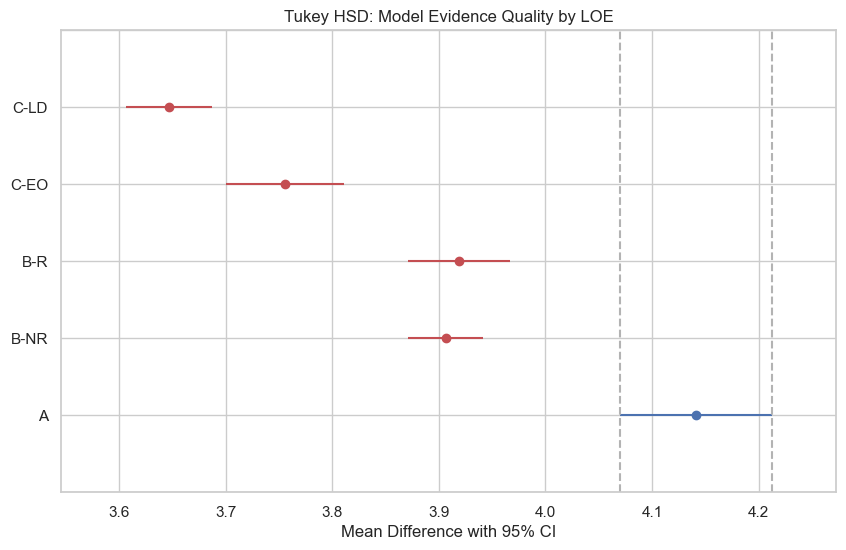

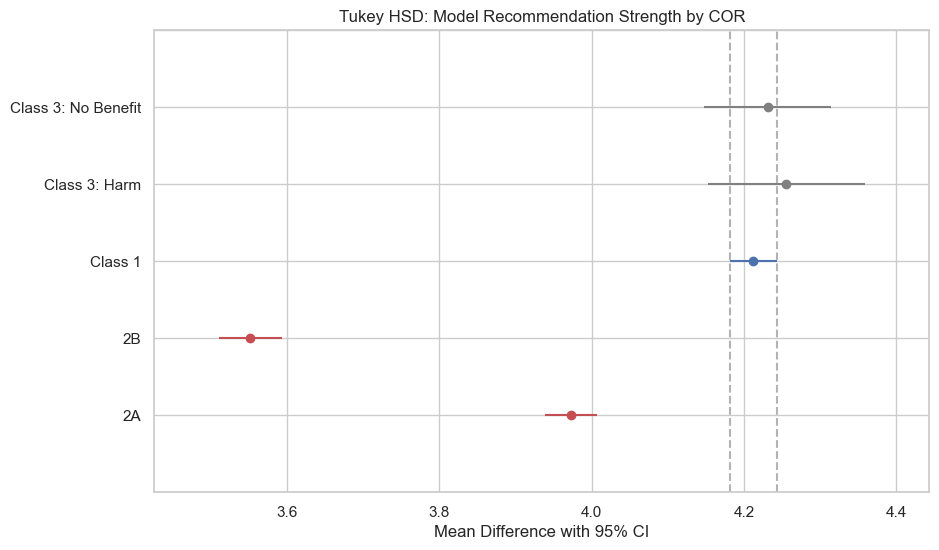

In [11]:
import pandas as pd


loe_order = ["A", "B-R", "B-NR", "C-LD", "C-EO"]
loe_data = df[["model_evidence_quality", "ground_truth_loe"]].dropna().copy()
loe_data["ground_truth_loe"] = pd.Categorical(loe_data["ground_truth_loe"], categories=loe_order, ordered=True)

# Tukey HSD for LOE
tukey_loeq = pairwise_tukeyhsd(endog=loe_data["model_evidence_quality"],
                               groups=loe_data["ground_truth_loe"],
                               alpha=0.05)

fig1 = tukey_loeq.plot_simultaneous(comparison_name="A")  
plt.title("Tukey HSD: Model Evidence Quality by LOE")
plt.xlabel("Mean Difference with 95% CI")
plt.grid(True)


cor_order = ["Class 1", "2A", "2B", "Class 3: No Benefit", "Class 3: Harm"]
cor_data = df[["model_recommendation_strength", "normalized_cor"]].dropna().copy()
cor_data["normalized_cor"] = pd.Categorical(cor_data["normalized_cor"], categories=cor_order, ordered=True)

# Tukey HSD for COR
tukey_cors = pairwise_tukeyhsd(endog=cor_data["model_recommendation_strength"],
                               groups=cor_data["normalized_cor"],
                               alpha=0.05)

fig2 = tukey_cors.plot_simultaneous(comparison_name="Class 1")
plt.title("Tukey HSD: Model Recommendation Strength by COR")
plt.xlabel("Mean Difference with 95% CI")
plt.grid(True)

plt.show()


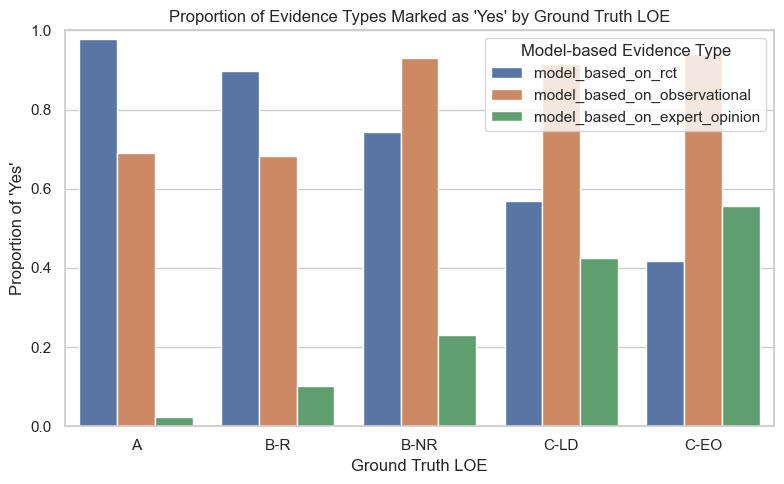

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Select relevant columns
cols = ["ground_truth_loe", "model_based_on_rct", "model_based_on_observational", "model_based_on_expert_opinion"]

# Filter and normalize
df_subset = df[cols].copy()
for col in cols[1:]:
    df_subset[col] = df_subset[col].str.strip().str.capitalize()  # Normalize "Yes"/"No"/"Unknown"

# Compute proportion of "Yes" per LOE for each type
proportions = (
    df_subset.groupby("ground_truth_loe")[
        ["model_based_on_rct", "model_based_on_observational", "model_based_on_expert_opinion"]
    ]
    .apply(lambda x: (x == "Yes").mean())
    .reset_index()
    .melt(id_vars="ground_truth_loe", var_name="Evidence Type", value_name="Proportion")
)

# Optional: Order LOE groups
loe_order = ["A", "B-R", "B-NR", "C-LD", "C-EO"]
proportions["ground_truth_loe"] = pd.Categorical(proportions["ground_truth_loe"], categories=loe_order, ordered=True)
proportions = proportions.sort_values("ground_truth_loe")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=proportions, x="ground_truth_loe", y="Proportion", hue="Evidence Type")
plt.title("Proportion of Evidence Types Marked as 'Yes' by Ground Truth LOE")
plt.xlabel("Ground Truth LOE")
plt.ylabel("Proportion of 'Yes'")
plt.ylim(0, 1)
plt.legend(title="Model-based Evidence Type")
plt.tight_layout()
plt.show()


Test other questions forms: paraphrased, negated and multiple-choice questions

=== Negated Recommendation Evaluation Summary ===
model_supported
No         0.688880
Yes        0.292522
Unknown    0.018597
Name: count, dtype: float64


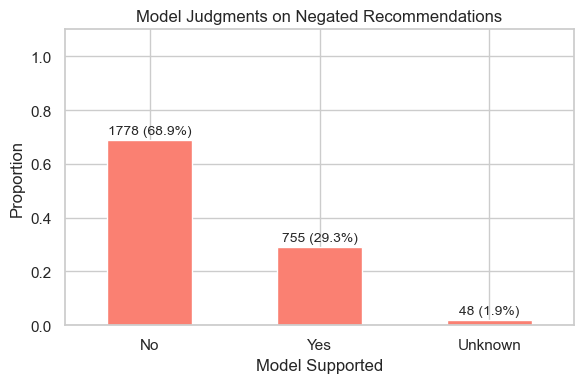

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load evaluation result ===
with open("negated_eval.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df_neg = pd.DataFrame.from_dict(data, orient="index")

# Filter valid responses only (Yes, No, Unknown)
valid_responses = ["Yes", "No", "Unknown"]
df_neg = df_neg[df_neg["model_supported"].isin(valid_responses)]

# Count proportions
support_counts = df_neg["model_supported"].value_counts()
support_props = support_counts / support_counts.sum()

# Print result
print("=== Negated Recommendation Evaluation Summary ===")
print(support_props)

# Plot
plt.figure(figsize=(6, 4))
ax = support_props.plot(kind="bar", color="salmon")
for i, label in enumerate(support_props.index):
    count = support_counts[label]
    pct = support_props[label]
    ax.text(i, pct + 0.01, f"{count} ({pct:.1%})", ha='center', va='bottom', fontsize=10)

plt.title("Model Judgments on Negated Recommendations")
plt.xlabel("Model Supported")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


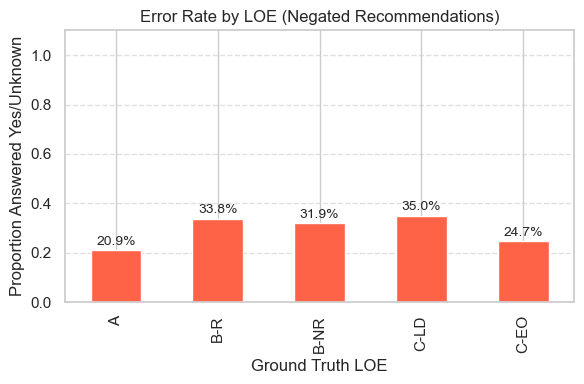

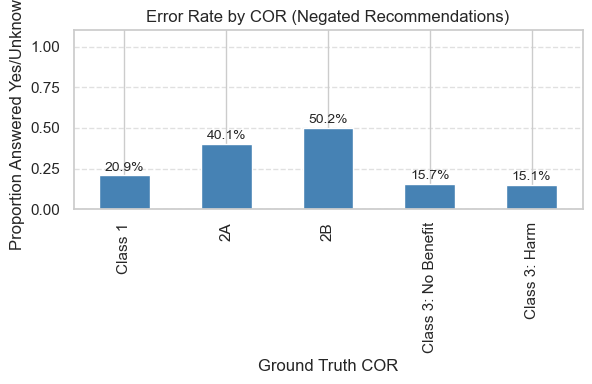

In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# === Load model output ===
with open("negated_eval.json", "r") as f:
    model_data = json.load(f)
df_model = pd.DataFrame.from_dict(model_data, orient="index").reset_index().rename(columns={"index": "id"})
df_model["id"] = df_model["id"].astype(str)

# === Load ground truth LOE ===
df_orig = pd.read_csv("aha_guideline_evidence_cleaned.csv")
df_orig["id"] = df_orig["id"].astype(str)

# === Merge
df = pd.merge(df_model, df_orig[["id", "LOE"]], on="id", how="left")

# === Mark error responses (model says Yes or Unknown)
df["is_error"] = df["model_supported"].isin(["Yes", "Unknown"])

# === Group by LOE and compute proportion of error
loe_order = ["A", "B-R", "B-NR", "C-LD", "C-EO"]
summary = df.groupby("LOE")["is_error"].mean().reindex(loe_order)

# === Plot
plt.figure(figsize=(6, 4))
ax = summary.plot(kind="bar", color="tomato")
for i, v in enumerate(summary):
    ax.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.title("Error Rate by LOE (Negated Recommendations)")
plt.ylabel("Proportion Answered Yes/Unknown")
plt.xlabel("Ground Truth LOE")
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# === Mark COR-based error rates
df = pd.merge(df_model, df_orig[["id", "COR"]], on="id", how="left")
df["is_error"] = df["model_supported"].isin(["Yes", "Unknown"])

# === Group by COR and compute error rate
cor_order = ["Class 1", "2A", "2B", "Class 3: No Benefit", "Class 3: Harm"]
summary_cor = df.groupby("COR")["is_error"].mean().reindex(cor_order)

# === Plot
plt.figure(figsize=(6, 4))
ax = summary_cor.plot(kind="bar", color="steelblue")
for i, v in enumerate(summary_cor):
    ax.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom', fontsize=10)

plt.title("Error Rate by COR (Negated Recommendations)")
plt.ylabel("Proportion Answered Yes/Unknown")
plt.xlabel("Ground Truth COR")
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


=== Proportion of model_supported values (Paraphrased) ===
model_supported
Yes        0.905463
Unknown    0.053468
No         0.041069
Name: count, dtype: float64


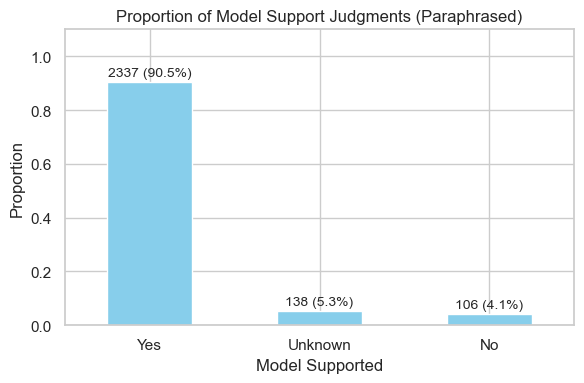

In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# === 1. Load JSON data ===
with open("paraphrased_eval.json", "r") as f:
    data = json.load(f)

# Convert dictionary to DataFrame
df_paraphrased_eval = pd.DataFrame.from_dict(data, orient="index")

# === 2. Compute count and proportion
support_counts_abs = df_paraphrased_eval["model_supported"].value_counts()
support_counts = support_counts_abs / support_counts_abs.sum()

print("=== Proportion of model_supported values (Paraphrased) ===")
print(support_counts)

# Bar plot with value labels
plt.figure(figsize=(6, 4))
ax = support_counts.plot(kind="bar", color="skyblue")

# Add text labels (count + percentage)
for i, label in enumerate(support_counts.index):
    count = support_counts_abs[label]
    pct = support_counts[label]
    ax.text(i, pct + 0.01, f"{count} ({pct:.1%})", ha='center', va='bottom', fontsize=10)

# Final formatting
plt.title("Proportion of Model Support Judgments (Paraphrased)")
plt.xlabel("Model Supported")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


# =====

# === Load model predictions from paraphrased_eval.json ===
with open("paraphrased_eval.json", "r") as f:
    paraphrased_data = json.load(f)
df_paraphrased_eval = pd.DataFrame.from_dict(paraphrased_data, orient="index")
df_paraphrased_eval.reset_index(inplace=True)
df_paraphrased_eval.rename(columns={"index": "id"}, inplace=True)

# === Load ground truth info from original CSV ===
df_gt = pd.read_csv("aha_guideline_evidence_cleaned.csv")[["id", "LOE", "COR"]]

# === Merge on 'id'
merged_df = pd.merge(df_paraphrased_eval, df_gt, on="id", how="left")

# === Filter where model_supported is No or Unknown
unsupported_df = merged_df[merged_df["model_supported"].isin(["No", "Unknown"])]


In [11]:
import json
import pandas as pd

# === Load the evaluation result JSON ===
with open("mcq_eval_results.json", "r") as f:
    data = json.load(f)

# === Convert to DataFrame
df = pd.DataFrame(data)

# === Clean model answer
df["model_answer"] = df["model_answer"].str.strip().str.upper()

# === Compute accuracy
df["is_correct"] = df["model_answer"] == df["ground_truth"]

# === Overall accuracy
overall_acc = df["is_correct"].mean()
print(f"Overall Accuracy: {overall_acc:.2%} ({df['is_correct'].sum()} / {len(df)})")

# === Accuracy by question_type
type_grouped = df.groupby("question_type")["is_correct"].agg(["mean", "count", "sum"])
type_grouped["accuracy"] = type_grouped["sum"] / type_grouped["count"]

print("\nAccuracy by Question Type:")
print(type_grouped[["accuracy", "count"]].rename(columns={"accuracy": "Accuracy", "count": "Num Questions"}))


Overall Accuracy: 92.50% (925 / 1000)

Accuracy by Question Type:
               Accuracy  Num Questions
question_type                         
1              0.927734            512
2              0.922131            488


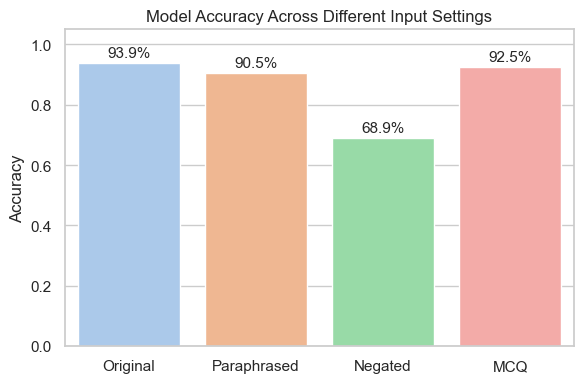

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# === Helper function to compute accuracy from JSON ===
def compute_accuracy_from_json(path, supported_key="model_supported", correct_values=["Yes"]):
    with open(path, "r") as f:
        data = json.load(f)
    df = pd.DataFrame.from_dict(data, orient="index")
    df = df[df[supported_key].isin(correct_values)]
    return len(df), df.shape[0]

# === 1. Original (evidence_eval_results.json) ===
with open("evidence_eval_results.json", "r") as f:
    data = json.load(f)
df_ori = pd.DataFrame.from_dict(data, orient="index")
acc_ori = (df_ori["model_supported"] == "Yes").mean()

# === 2. Negated (negated_eval.json) ===
with open("negated_eval.json", "r") as f:
    data = json.load(f)
df_neg = pd.DataFrame.from_dict(data, orient="index")
df_neg = df_neg[df_neg["model_supported"].isin(["Yes", "No", "Unknown"])]
acc_neg = (df_neg["model_supported"] == "No").mean()

# === 3. Paraphrased (paraphrased_eval.json) ===
with open("paraphrased_eval.json", "r") as f:
    data = json.load(f)
df_para = pd.DataFrame.from_dict(data, orient="index")
acc_para = (df_para["model_supported"] == "Yes").mean()

# === 4. MCQ (mcq_eval_results.json) ===
with open("mcq_eval_results.json", "r") as f:
    mcq_data = json.load(f)
df_mcq = pd.DataFrame(mcq_data)
df_mcq["model_answer"] = df_mcq["model_answer"].str.strip().str.upper()
acc_mcq = (df_mcq["model_answer"] == df_mcq["ground_truth"]).mean()

# === Combine results ===
acc_results = pd.DataFrame({
    "Setting": ["Original", "Paraphrased", "Negated", "MCQ"],
    "Accuracy": [acc_ori, acc_para, acc_neg, acc_mcq]
})

# === Plot ===
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="Setting", y="Accuracy", data=acc_results, palette="pastel")

# Add labels
for i, row in acc_results.iterrows():
    ax.text(i, row["Accuracy"] + 0.01, f"{row['Accuracy']:.1%}", ha='center', va='bottom', fontsize=11)

plt.title("Model Accuracy Across Different Input Settings")
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.xlabel("")
plt.tight_layout()
plt.show()
